# Diplomski rad 02
28\. veljače 2017.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.debugger import Tracer
from itertools import groupby
import graphviz as gv
import networkx as nx
import pydot

matplotlib.rcParams['figure.figsize'] = (12, 5)


- Konvencija: vremenski nizovi spremljeni su kao vektor-stupci
- **sp500** je matrica s cijenama dionica, **sp500_log** je matrica s logaritmima cijena dionica
- Definicija: **gornje-prizmoidni (3-D) tenzor** je tenzor koji duž prve dimenzije sadrži gornje-trokutaste matrice


## Funkcije
- `rolling_mean_variance(series, T)` računa očekivanje i varijancu nad zadanim podacima (`series`) nad pomičnim prozorom širine `T`
- `flatten_prismatic_tensor(K)` pretvara gornje-prizmoidni 3-D tenzor u 2-D tenzor koji u retcima sadrži izravnate gornje-trokutaste matrice originalnog tenzora
- `encode_pair`
- `encode_pairs`
- `decode_pair`
- `decode_pairs`


In [11]:
def rolling_mean_variance(series, T):
    L, N = series.shape
    if (L < T):
        return np.empty((0, N)), np.empty((0, N))
    mean = np.zeros((L - T + 1, N))
    var = np.zeros((L - T + 1, N))
    s0 = T * np.ones((1, N))
    s1 = np.sum(series[:T - 1, :], axis=0, keepdims=True)
    s2 = np.sum(series[:T - 1, :] ** 2, axis=0, keepdims=True)
    s1_prev = np.zeros((1, N))
    s2_prev = np.zeros((1, N))
    for i in range(L - T + 1):
        s1 += series[i + T - 1, :] - s1_prev
        s2 += series[i + T - 1, :] ** 2 - s2_prev
        s1_prev = series[i, :]
        s2_prev = series[i, :] ** 2
        mean[i, :] = s1 / s0
        var[i, :] = (s0 * s2 - s1 * s1) / (s0 * (s0 - 1))
    return mean, var

def rolling_window(series, T):
    shape = series.shape[:-1] + (series.shape[-1] - T + 1, T)
    strides = series.strides + (series.strides[-1],)
    return np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)

def rolling_minmax(series, T, minmax='min'):
    if minmax == 'min':
        np_argfun = np.argmin
        np_fun = np.min
    elif minmax == 'max':
        np_argfun = np.argmax
        np_fun = np.max
    else:
        raise Exception('"minmax" should be either "min" or "max".')
    
    # non-optimal
    return np_fun(rolling_window(series.transpose(), T), axis=1).transpose()

def flatten_prismatic_tensor(K):
    _, N, M = K.shape
    if N != M:
        raise Exception('Two lowest dimensions must be equal.')
    return np.array(list(map(lambda x: x[np.triu_indices(N, 1)], K)))

def calculate_pairwise_diffs(prices):
    days, N = prices.shape
    diffs = np.zeros((days, N, N))
    for i in range(N):
        for j in range(i + 1, N):
            diffs[:, i, j] = prices[:, i] - prices[:, j]
    return flatten_prismatic_tensor(diffs)

def pairs_from_N(N):
    return int(N * (N - 1) / 2)

def N_from_pairs(P):
    return int((np.sqrt(8 * P + 1) + 1) / 2)

def encode_pair(i, j, N):
    if j < i:
        i, j = j, i
    return N * i + j - int((i + 1) * (i + 2) / 2)

def encode_pairs(ijs, N):
    return np.array([encode_pair(i, j, N) for i, j in ijs])

def decode_pair(c, N, inv=False):
    b = 2 * N - 1
    b2 = b * b
    return __decode_pair(c, N, b, b2, inv)

def decode_pairs(cs, N, inv=False):
    b = 2 * N - 1
    b2 = b * b
    return np.array(np.vectorize(lambda c: __decode_pair(c, N, b, b2, inv))(cs)).transpose()
        
def __decode_pair(c, N, b, b2, inv):
    i = int((b - np.sqrt(b2 - 8 * c)) / 2) + 1
    j = c - N * i + int((i + 1) * (i + 2) / 2) + 1
    if inv:
        return j, i
    else:
        return i, j

def trade_pair(diffs, t, pair, inv=False):
    P = diffs.shape[1]
    N = N_from_pairs(P)
    
    if isinstance(pair, tuple):
        i, j = tuple
        c = encode_pair(i, j, N)
    elif np.issubdtype(pair, np.integer):
        c = pair
    else:
        raise Exception('"pair" should be either tuple or int.')
        
    return (1 - 2 * inv) * (diffs[t, c] - diffs[t + 1, c])

def trade_pairs(diffs, ts, pairs, inv=False):
    P = diffs.shape[1]
    N = int(np.sqrt(8 * P + 1) / 2 - 1.5)
    
    if len(pairs.shape) == 2:
        cs = encode_pairs(pairs, N)
    elif len(pairs.shape) == 1:
        cs = pairs
    else:
        raise Exception('"pairs" should be one- or two-dimensional.')
        
    return np.array([trade_pair(diffs, t, c, inv) for t, c in zip(ts, cs)])

def select_argsort(matrix, argsort):
    n, _ = matrix.shape
    _, l = argsort.shape
    return matrix[np.arange(n).repeat(l), argsort.ravel()].reshape((n, l))

def statistical_arbitrage(diffs, means, varss, p, d, method='thresh-devs', scale=True, return_pairs=False):
    T = diffs.shape[0] - means.shape[0] + 1
    P = diffs.shape[1]
    L = means.shape[0]
    N = N_from_pairs(P)
    
    if 'thresh' not in method:
        if isinstance(p, float):
            p = int(p * P)
        elif not isinstance(p, int):
            raise Exception('"p" should be either int or float.')
        
        selected_codes = np.argsort(varss, axis=1)[:-1, :p]
        selected_diffs = select_argsort(diffs[T - 1:-1, :], selected_codes)
        selected_means = select_argsort(means[:-1, :], selected_codes)
        selected_vars = select_argsort(varss[:-1, :], selected_codes)
    
    if method == 'thresh-devs':
        selected_codes = varss[:-1, :] <= p
        ts, cs = np.nonzero(selected_codes)
        selected_means = means[:-1, :][selected_codes]
        selected_vars = varss[:-1, :][selected_codes]
        lower_bounds = selected_means - d * np.sqrt(selected_vars)
        upper_bounds = selected_means + d * np.sqrt(selected_vars)
        del(selected_means, selected_vars)
        selected_diffs = diffs[T - 1:-1, :][selected_codes]
        invs = np.less(selected_diffs, lower_bounds)
        no_invs = np.greater(selected_diffs, upper_bounds)
        del(selected_diffs, upper_bounds, lower_bounds)
        ts_invs = ts[invs] + T - 1
        ts_no_invs = ts[no_invs] + T - 1
        invs = cs[invs]
        no_invs = cs[no_invs]
        del(ts, cs)
        
    elif method == 'devs':
        lower_bounds = selected_means - d * np.sqrt(selected_vars)
        upper_bounds = selected_means + d * np.sqrt(selected_vars)
        ts_invs, invs = np.nonzero(np.less(selected_diffs, lower_bounds))
        ts_no_invs, no_invs = np.nonzero(np.greater(selected_diffs, upper_bounds))
        invs = selected_codes[ts_invs, invs]
        no_invs = selected_codes[ts_no_invs, no_invs]
        ts_invs += T - 1
        ts_no_invs += T - 1
        
    elif method == 'max-abs-devs':
        max_abs_devs = select_argsort(
            np.max(np.abs(rolling_window(diffs.transpose(), T).transpose() - means), axis=0)[:-1, :],
            selected_codes)
        lower_bounds = selected_means - d * max_abs_devs
        upper_bounds = selected_means + d * max_abs_devs
        ts_invs, invs = np.nonzero(np.less(selected_diffs[1:, :], lower_bounds[:-1, :]))
        ts_no_invs, no_invs = np.nonzero(np.greater(selected_diffs[1:, :], upper_bounds[:-1, :]))
        ts_invs += 1
        ts_no_invs += 1
        invs = selected_codes[ts_invs, invs]
        no_invs = selected_codes[ts_no_invs, no_invs]
        ts_invs += T - 1
        ts_no_invs += T - 1
        
    else:
        raise Exception('Method not supported.')
        
    invs_profit = trade_pairs(diffs, ts_invs, invs, True)
    no_invs_profit = trade_pairs(diffs, ts_no_invs, no_invs, False)
    ts_total = np.append(ts_invs, ts_no_invs)
    ts_order = np.argsort(ts_total)
    profit = np.append(invs_profit, no_invs_profit)[ts_order]
    ts_total = ts_total[ts_order]
    
    if return_pairs:
        pairs = np.vstack((decode_pairs(invs, N, inv=True),
                           decode_pairs(no_invs, N, inv=False)))[ts_order, :]
        
    
    if scale:
        scales = [len(list(it)) for _, it in groupby(ts_total)]
        last_ts = None
        j = -1
        for i in range(len(profit)):
            if ts_total[i] != last_ts:
                last_ts = ts_total[i]
                j += 1
            profit[i] /= scales[j]                
    
    if return_pairs:
        return ts_total, profit, pairs
    return ts_total, profit

def partition_as(days, array):
    lens = [len(list(it)) for _, it in groupby(days)]
    i = 0
    j = 0
    n = len(array)
    while i != n:
        yield days[i], array[i:i + lens[j], ...]
        i += lens[j]
        j += 1


## Prikaz primjera distribucije srednjih vrijednosti i varijanci

- **sp500_log_diffs** je izravnati gornje-trokutasti tenzor koji sadrži razlike parova dionica za svaki dan
- **sp500_log_diff_means**, **sp500_log_diff_vars**

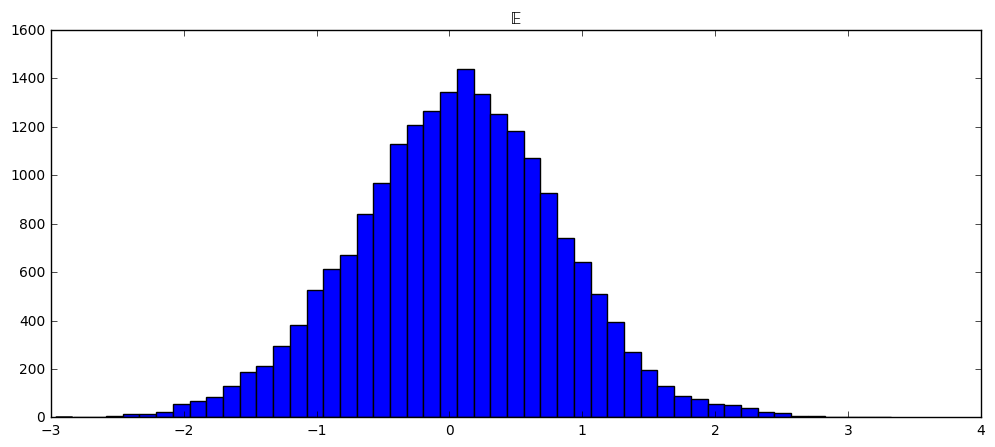

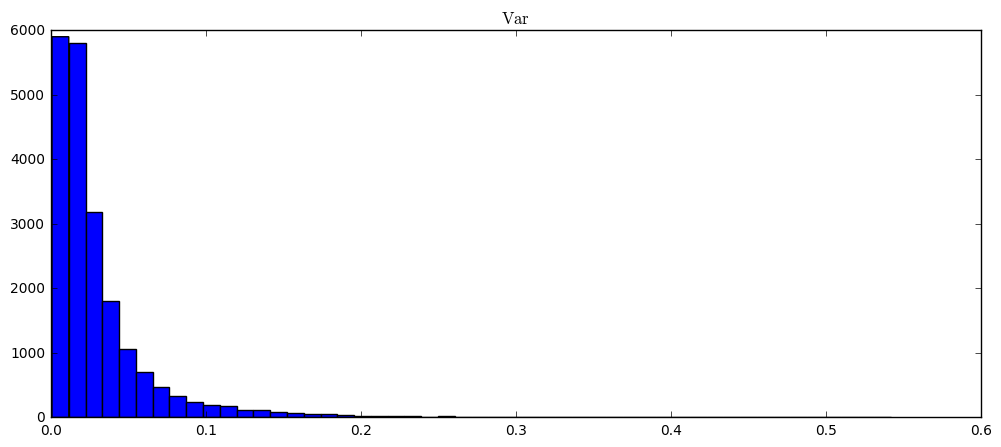

In [3]:
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

plt.figure()
plt.hist(sp500_log_diff_means[4321, :], 50)
plt.title('$\\mathrm{\\mathbb{E}}$')
plt.figure()
plt.hist(sp500_log_diff_vars[4321, :], 50);
plt.title('$\\mathrm{Var}$');

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)

## Prikaz parova dionica s najmanjim i najvećim varijancama

### Pobjednici

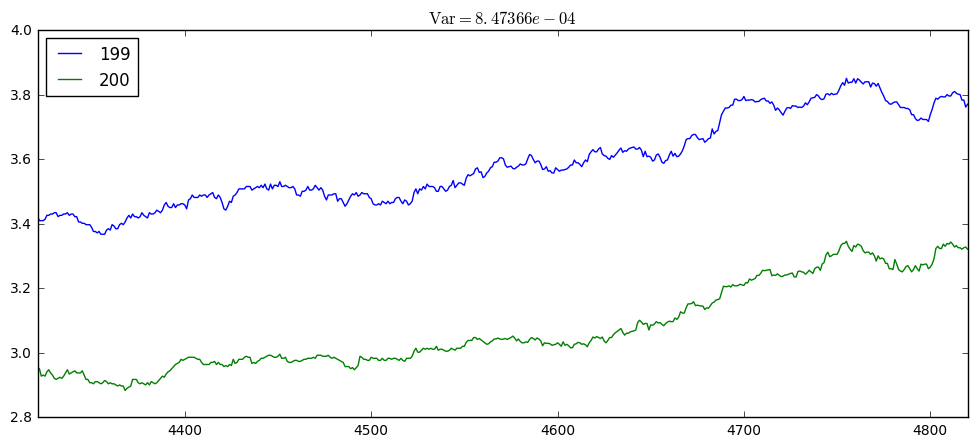

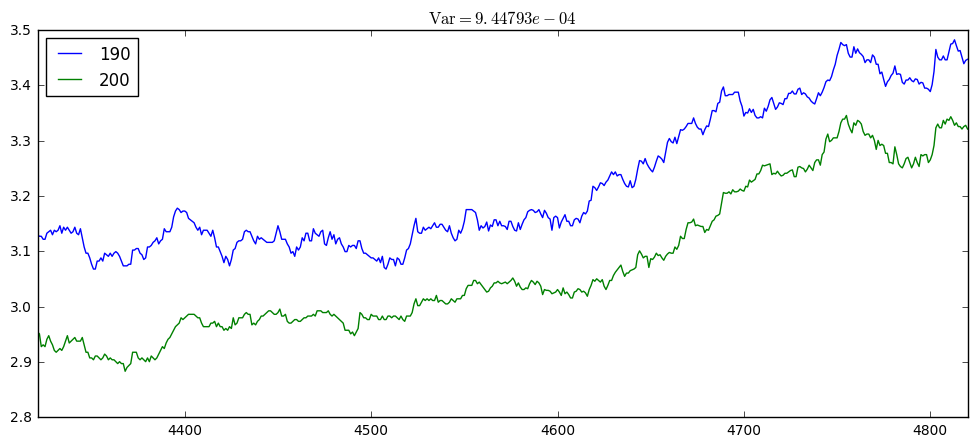

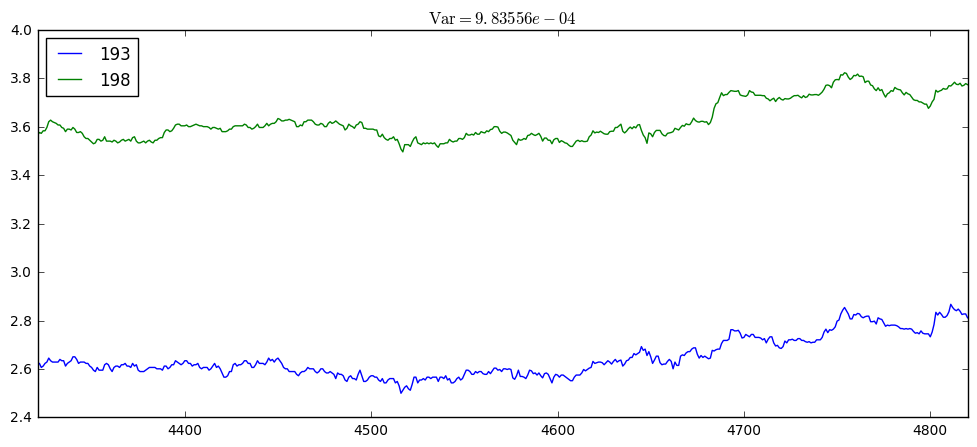

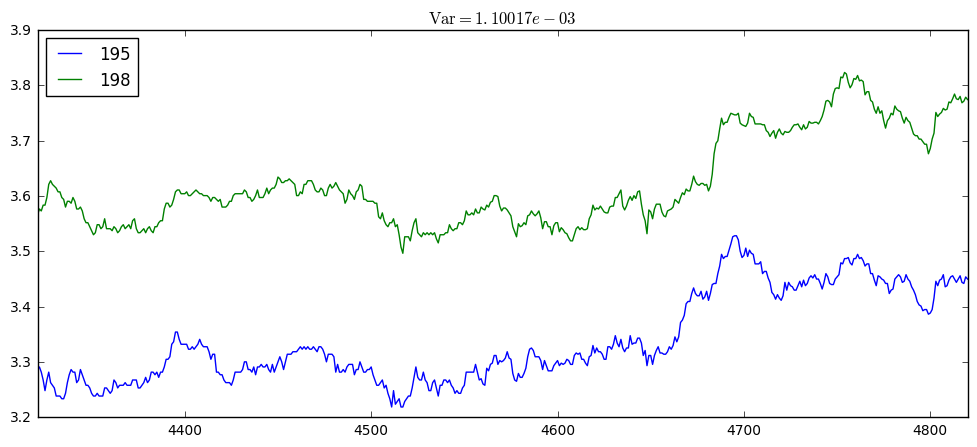

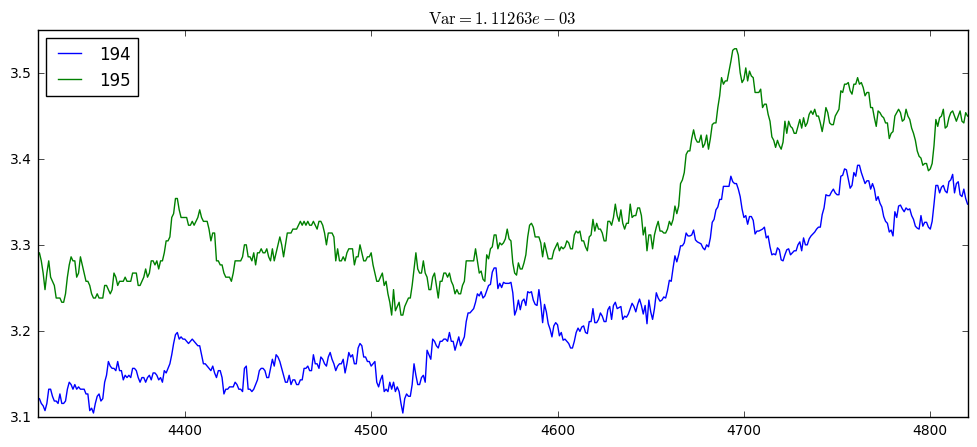

In [4]:
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
sp500_log_diff_stds = np.sqrt(sp500_log_diff_vars)

codes = sorted(list(range(pairs)), key=lambda c: sp500_log_diff_vars[4321, c])
sorted_vars = sorted(sp500_log_diff_vars[4321, :])
best = decode_pairs(codes[:5], N)
worst = decode_pairs(codes[-5:], N)

for (i, j), var in zip(best, sorted_vars[:5]):
    plt.figure()
    plt.plot(range(4321, 4321 + T), sp500_log[4321:4321 + T, i])
    plt.plot(range(4321, 4321 + T), sp500_log[4321:4321 + T, j])
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend((i, j), loc='best')
    plt.title('$\\mathrm{{Var}}={:.5e}$'.format(var))


### Gubitnici

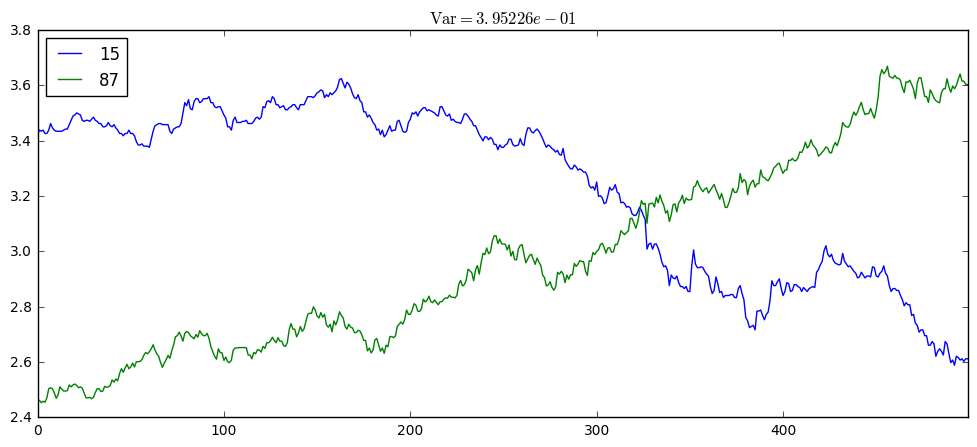

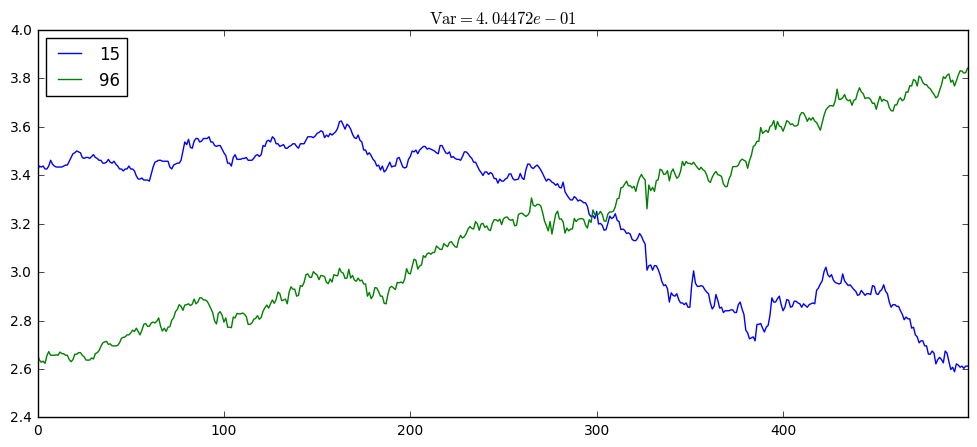

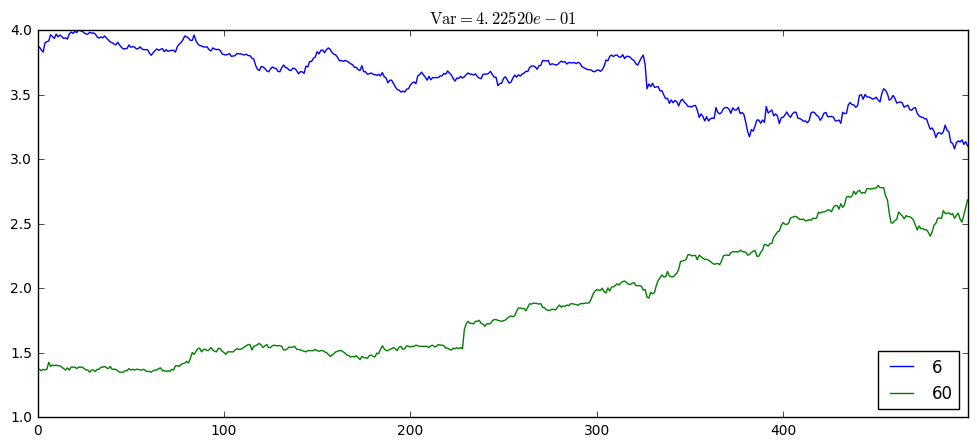

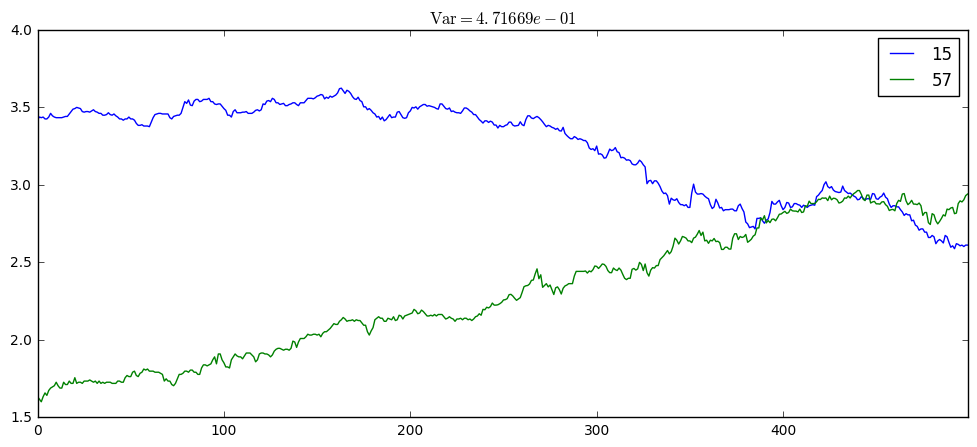

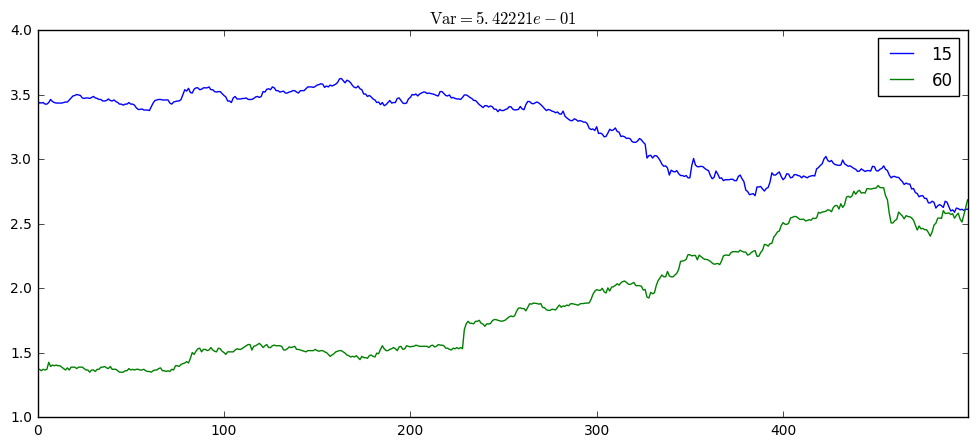

In [5]:
for (i, j), var in zip(worst, sorted_vars[-5:]):
    plt.figure()
    plt.plot(sp500_log[4321:4321 + T, i])
    plt.plot(sp500_log[4321:4321 + T, j])
    plt.legend((i, j), loc='best')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.title('$\\mathrm{{Var}}={:.5e}$'.format(var))
    

## Rasponi vrijednosti za parove s najmanjim varijancama

- **plavo:** dvije devijacije
- **zeleno:** polovica maksimalnog odstupanja

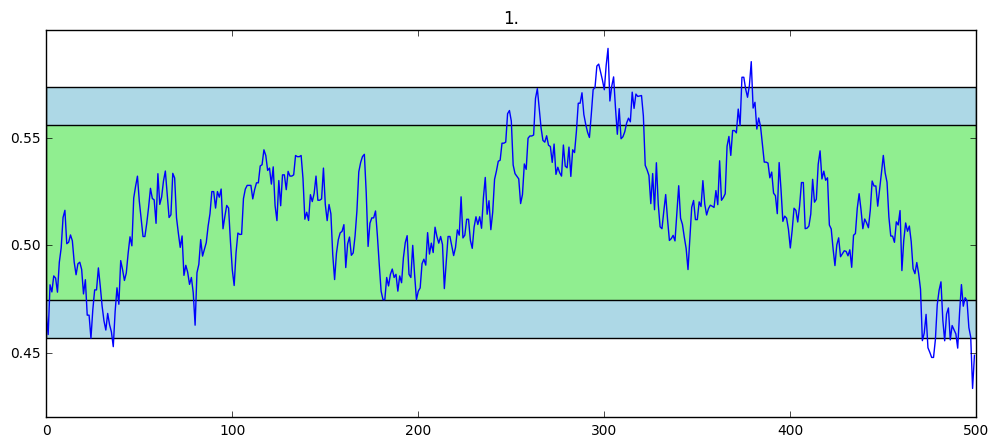

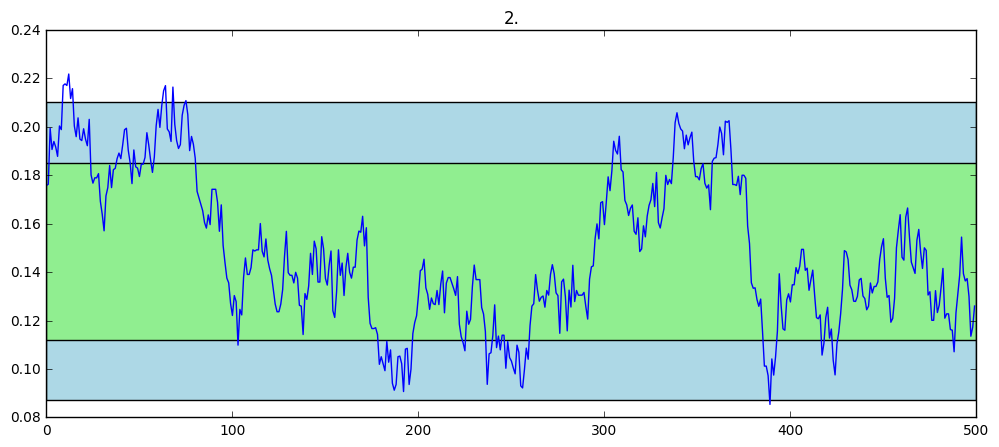

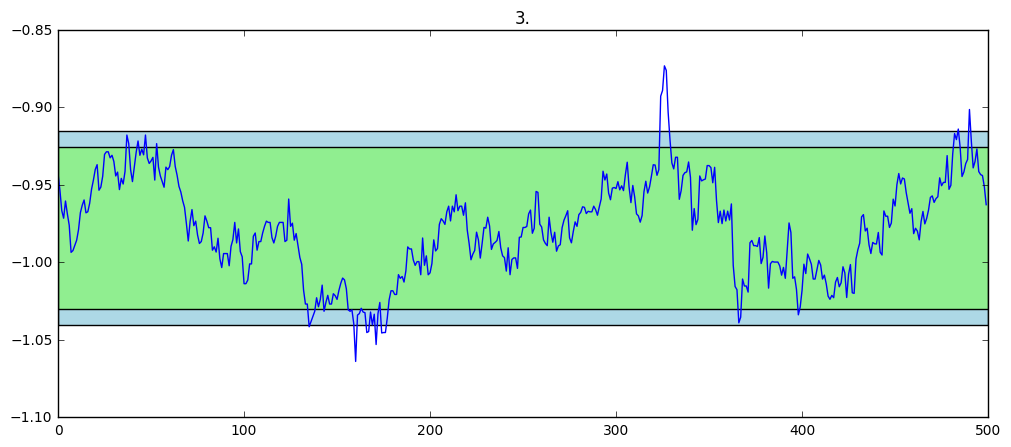

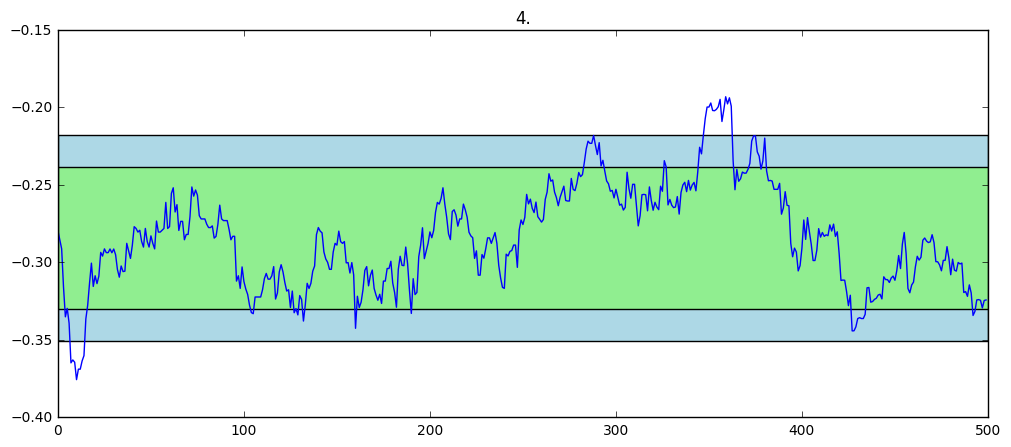

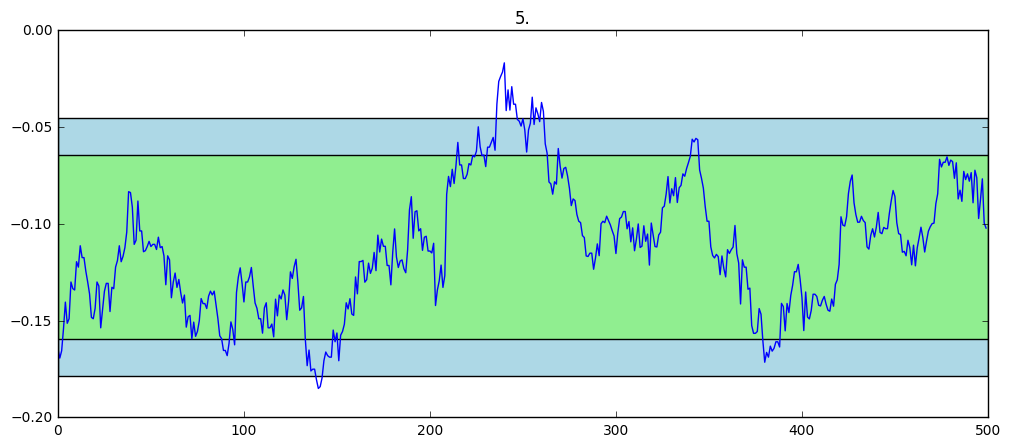

In [6]:
for i in range(5):
    plt.figure()
    plt.plot(sp500_log_diffs[4321:4321 + T, codes[i]])
    y1 = sp500_log_diff_means[4321, codes[i]] - 2 * sp500_log_diff_stds[4321, codes[i]]
    y2 = sp500_log_diff_means[4321, codes[i]] + 2 * sp500_log_diff_stds[4321, codes[i]]
    max_abs_dev = np.max(np.abs(sp500_log_diffs[4321:4321 + T - 1, codes[i]] - sp500_log_diff_means[4321, codes[i]]))
    z1 = sp500_log_diff_means[4321, codes[i]] - 0.5 * max_abs_dev
    z2 = sp500_log_diff_means[4321, codes[i]] + 0.5 * max_abs_dev
    plt.fill_between(range(501), y1, y2, facecolor='lightblue')
    plt.fill_between(range(501), z1, z2, facecolor='lightgreen')
    plt.title(str(i + 1) + '.')
    
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, sp500_log_diff_stds,
    codes, sorted_vars, best, worst)

# Statistička arbitraža

## Testiranje implementacije nad trivijalnim podacima

[[ 1.   1.  -2.6  0.  -3.6 -3.6]
 [ 1.2  1.2 -4.3  0.  -5.5 -5.5]
 [ 1.2  1.2 -2.5  0.  -3.7 -3.7]
 [ 1.2  1.2 -4.3  0.  -5.5 -5.5]
 [ 1.2  1.2 -2.5  0.  -3.7 -3.7]
 [ 1.2  1.2 -4.3  0.  -5.5 -5.5]
 [ 1.   1.  -2.6  0.  -3.6 -3.6]
 [ 0.8  0.8 -4.5  0.  -5.3 -5.3]
 [ 0.8  0.8 -2.7  0.  -3.5 -3.5]]
[[  0.     0.    24.3    0.    24.3   24.3 ]
 [  0.2    0.2   23.45   0.    25.25  25.25]
 [  0.2    0.2   23.     0.    25.7   25.7 ]
 [  0.2    0.2   23.45   0.    25.25  25.25]
 [  0.2    0.2   23.     0.    25.7   25.7 ]
 [  0.2    0.2   23.45   0.    25.25  25.25]
 [  0.     0.    24.3    0.    24.3   24.3 ]
 [  0.2    0.2   25.25   0.    23.45  23.45]
 [  0.2    0.2   25.7    0.    23.    23.  ]]
[ 5  5 11 11]
[ 0.5  0.5  0.5  0.5]


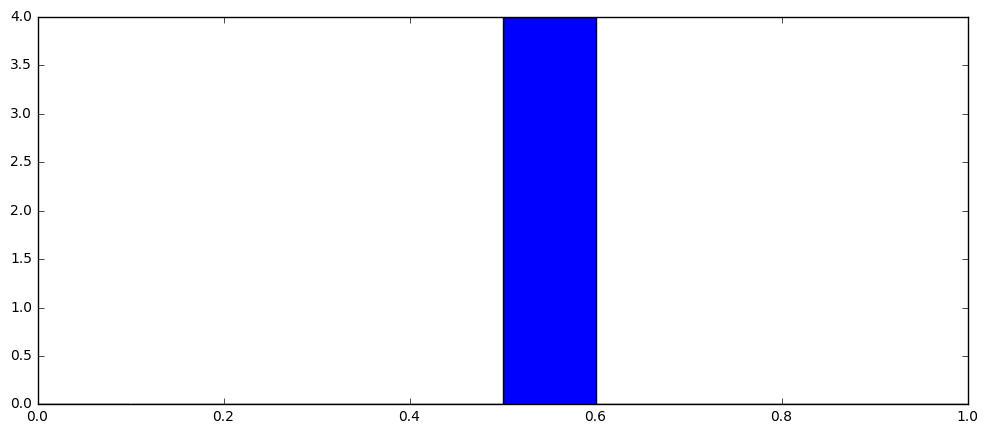

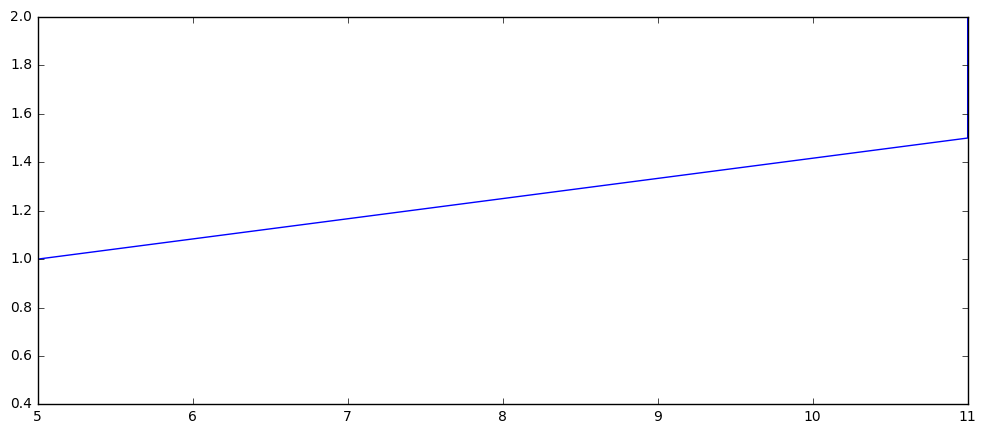

In [7]:
my_prices_logs = np.array([
        [2, 2, 2, 2, 2, 2.5, 2, 2, 2, 2, 2, 1.5, 2],
        [1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1.5, 1],
        [1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1.5, 1],
        [1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1]
        ]).transpose();

my_prices_diffs = calculate_pairwise_diffs(my_prices_logs)
my_prices_means, my_prices_vars = rolling_mean_variance(my_prices_diffs, 5)

ts, profit = statistical_arbitrage(my_prices_diffs, my_prices_means, my_prices_vars,
                                   1, 1, method='thresh-devs')

print(my_prices_means)
print(my_prices_vars)
print(ts)
print(profit)

plt.figure()
plt.hist(profit)
plt.figure()
plt.plot(ts, np.cumsum(profit));

## Variranje parametara p i d

### Metoda s fiksnim brojem parova p

p = 1, d = 1, profit = 2.1220242573330674, acc = 0.5428994082840237
p = 1, d = 1.5, profit = 1.5048623100425638, acc = 0.5393824826717076
p = 1, d = 2, profit = 0.7980151799479933, acc = 0.5208333333333334
p = 1, d = 2.5, profit = 0.6092372031058312, acc = 0.5539568345323741
p = 1, d = 3, profit = 0.24956525385334838, acc = 0.5643564356435643
p = 1, d = 3.5, profit = 0.2268084126225527, acc = 0.5471698113207547
p = 1, d = 4, profit = 0.001119137558573513, acc = 0.5178571428571429
p = 1, d = 4.5, profit = 0.08682746830334676, acc = 0.5238095238095238
p = 1, d = 5, profit = 0.08195663253014462, acc = 0.5666666666666667
p = 2, d = 1, profit = 3.1981427484774514, acc = 0.5182857142857142
p = 2, d = 1.5, profit = 2.454603025450116, acc = 0.5210312075983717
p = 2, d = 2, profit = 1.248796459008593, acc = 0.5114693118412895
p = 2, d = 2.5, profit = 1.226159947302776, acc = 0.5373891001267427
p = 2, d = 3, profit = 0.5204394051342867, acc = 0.5347593582887701
p = 2, d = 3.5, profit = 0.4780670

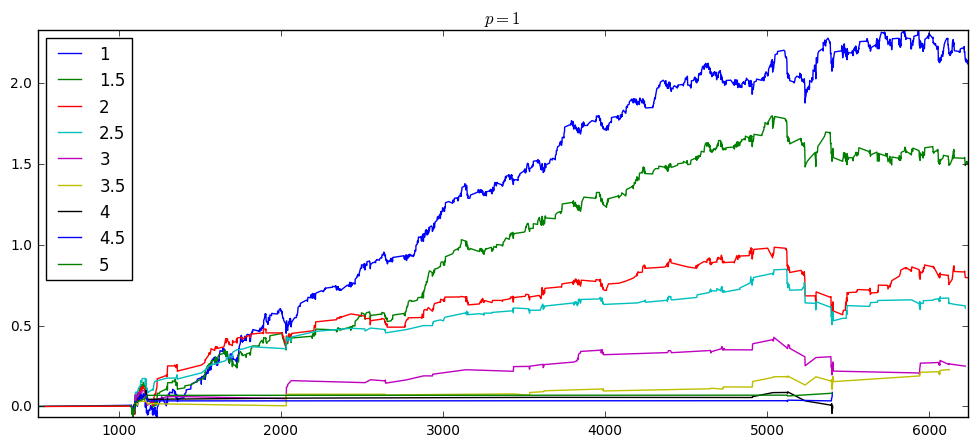

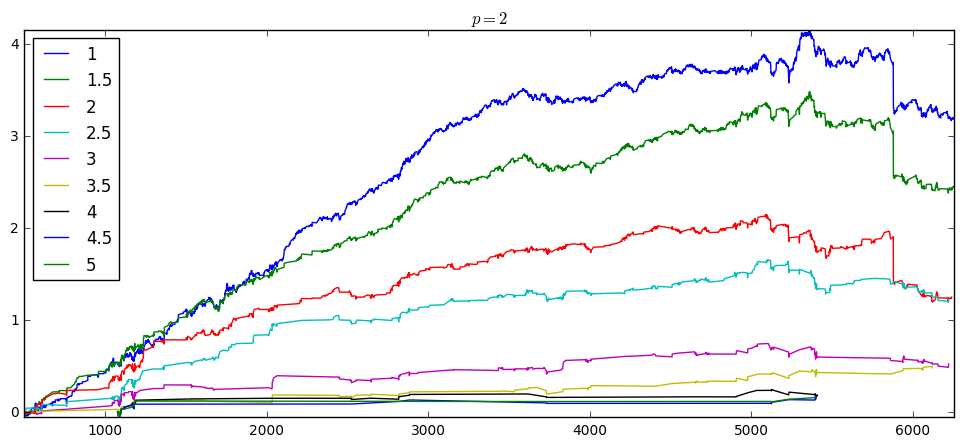

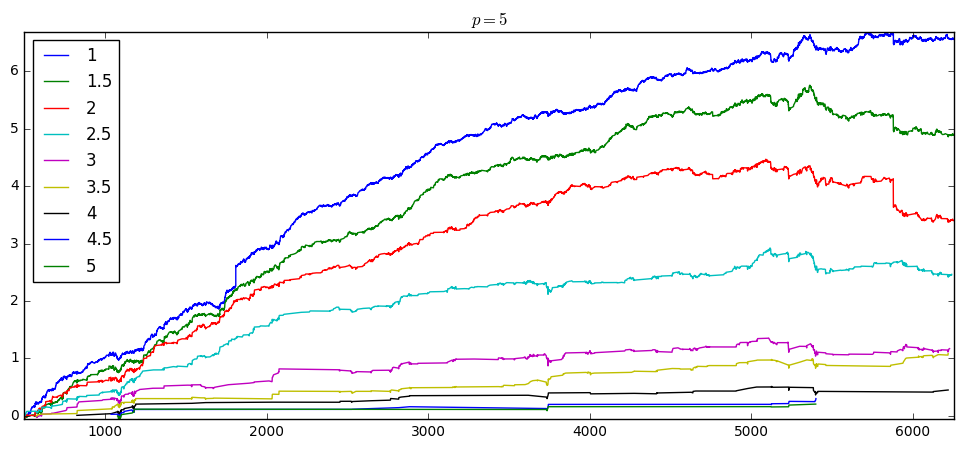

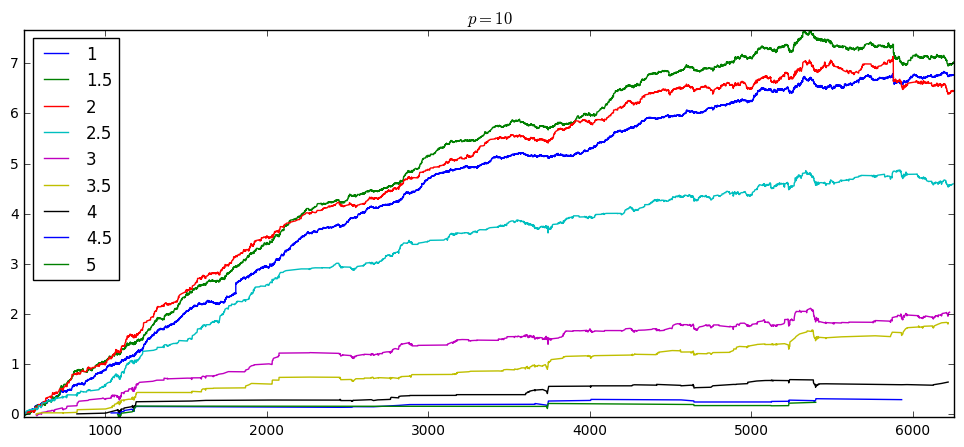

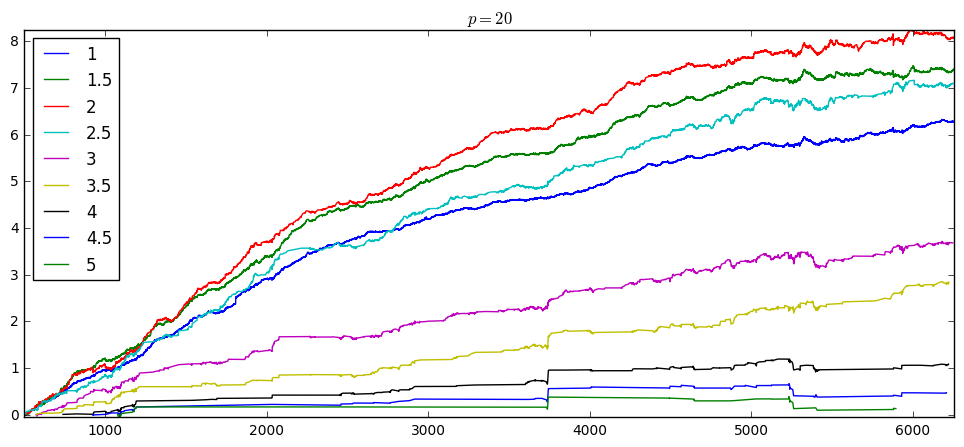

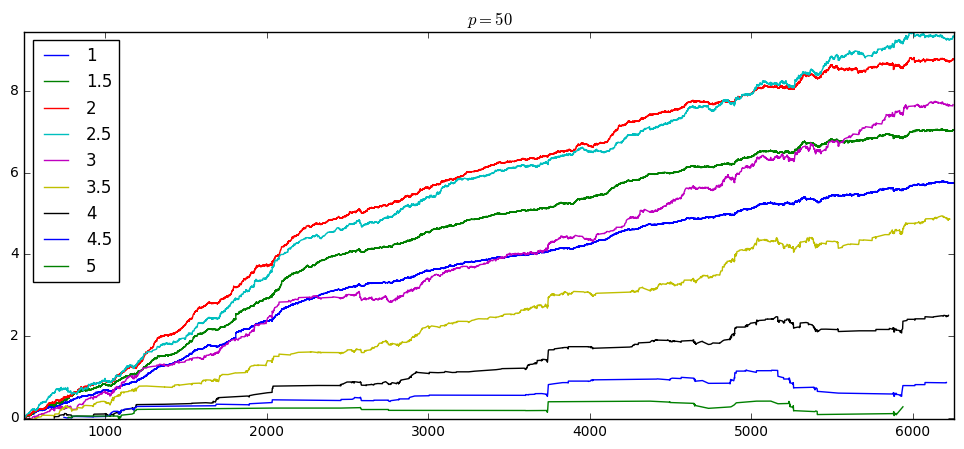

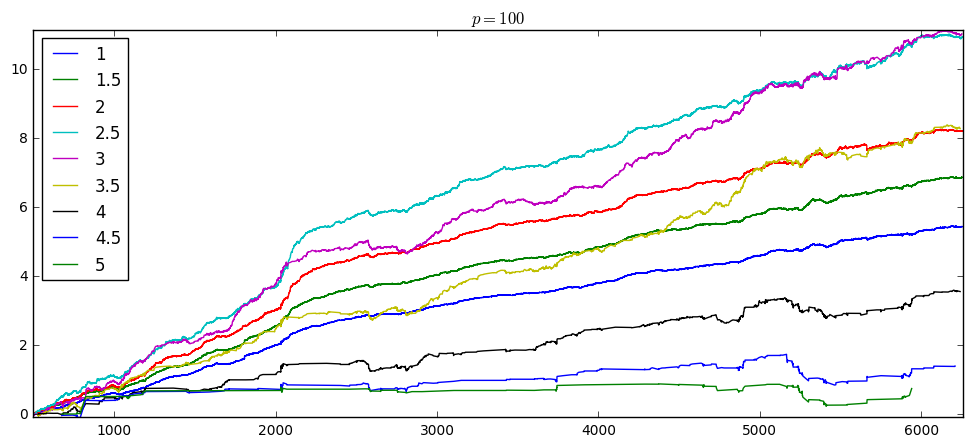

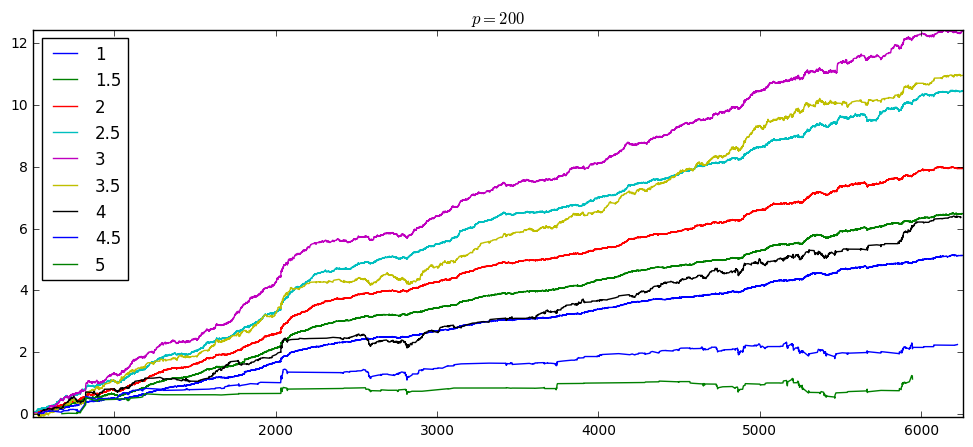

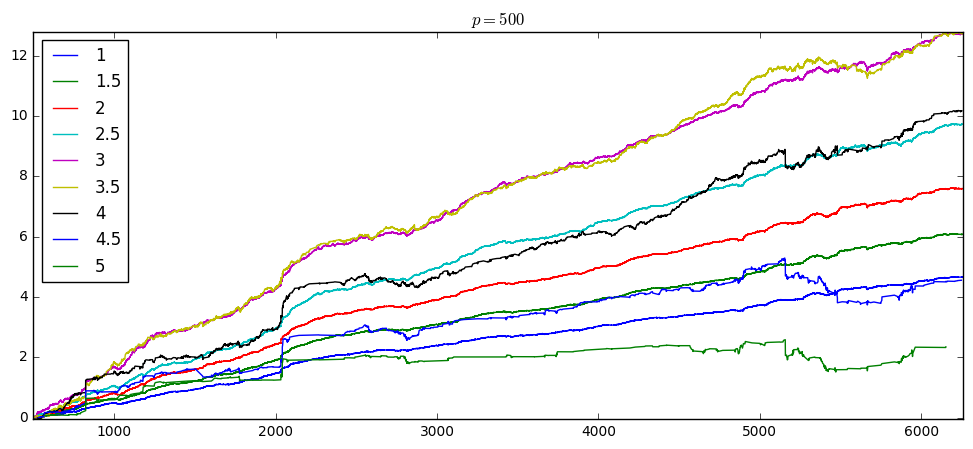

In [8]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

T = 500
ps = [1, 2, 5, 10, 20, 50, 100, 200, 500]
ds = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

for p in ps:
    plt.figure()
    plt.title('$p={}$'.format(p))
    for d in ds:
        ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                           p, d, method='devs')

        plt.plot(ts, np.cumsum(profit))
        plt.autoscale(enable=True, axis='x', tight=True)
        print('p = {}, d = {}, profit = {}, acc = {}'.format(p, d, np.sum(profit), np.sum(profit > 0) / len(profit)))
    plt.legend([str(d) for d in ds], loc='best')

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


### Metoda s fiksnim pragom varijacije

p = 0.001, d = 1, profit = 5.206361627067921, acc = 0.5072269944961679
p = 0.001, d = 1.5, profit = 5.4046824303980765, acc = 0.5126102842883878
p = 0.001, d = 2, profit = 4.659012584951163, acc = 0.5121252947120243
p = 0.001, d = 2.5, profit = 3.203622444317465, acc = 0.524328249818446
p = 0.001, d = 3, profit = 1.5197549815664502, acc = 0.5224252491694352
p = 0.001, d = 3.5, profit = 1.321748848619388, acc = 0.5743243243243243
p = 0.001, d = 4, profit = 0.6282804144121596, acc = 0.5962732919254659
p = 0.001, d = 4.5, profit = 0.258034979814159, acc = 0.5303030303030303
p = 0.001, d = 5, profit = 0.14966592833307013, acc = 0.5
p = 0.002, d = 1, profit = 5.3958400492570195, acc = 0.49803800082610494
p = 0.002, d = 1.5, profit = 6.205644792576967, acc = 0.501882236733798
p = 0.002, d = 2, profit = 7.011310653139463, acc = 0.508013659885609
p = 0.002, d = 2.5, profit = 7.80180526226245, acc = 0.5191148732575792
p = 0.002, d = 3, profit = 5.841775011779869, acc = 0.5239510689379215
p = 0.

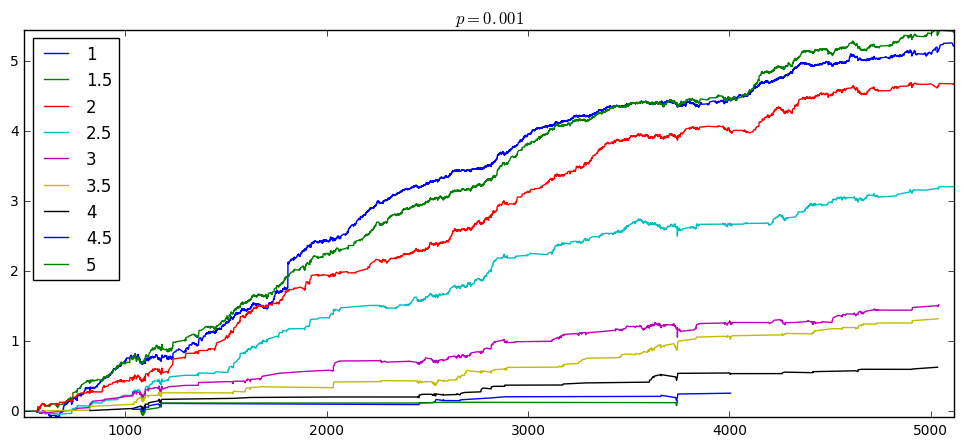

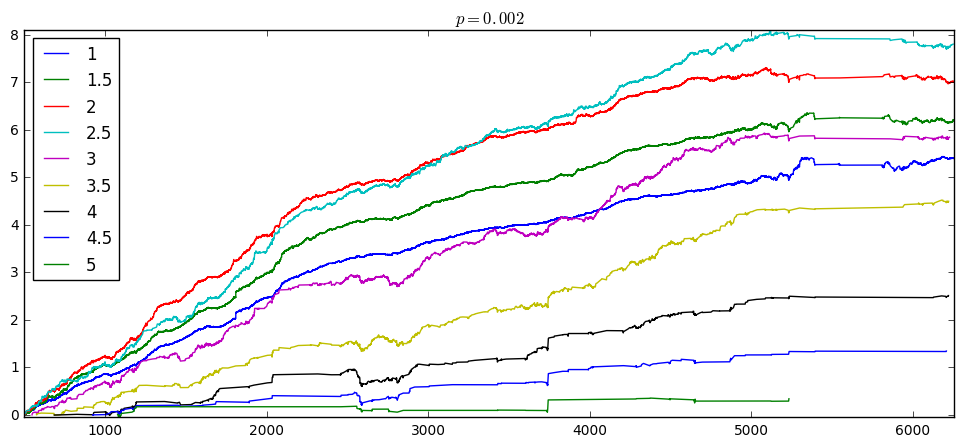

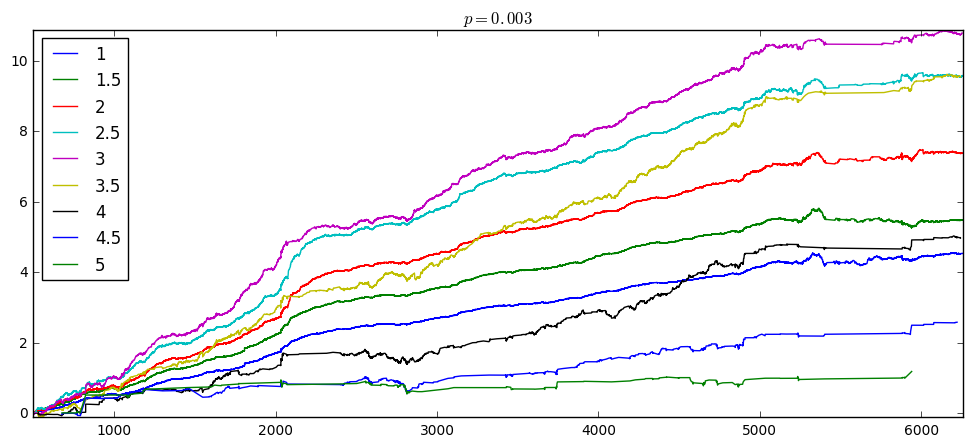

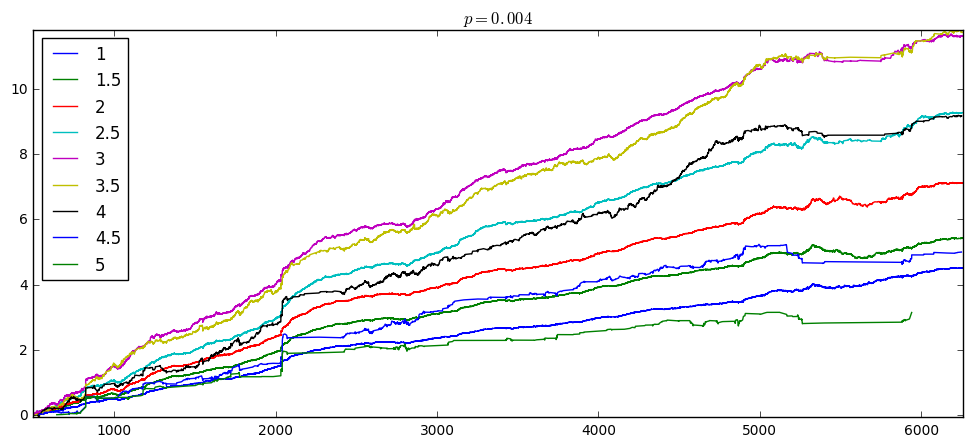

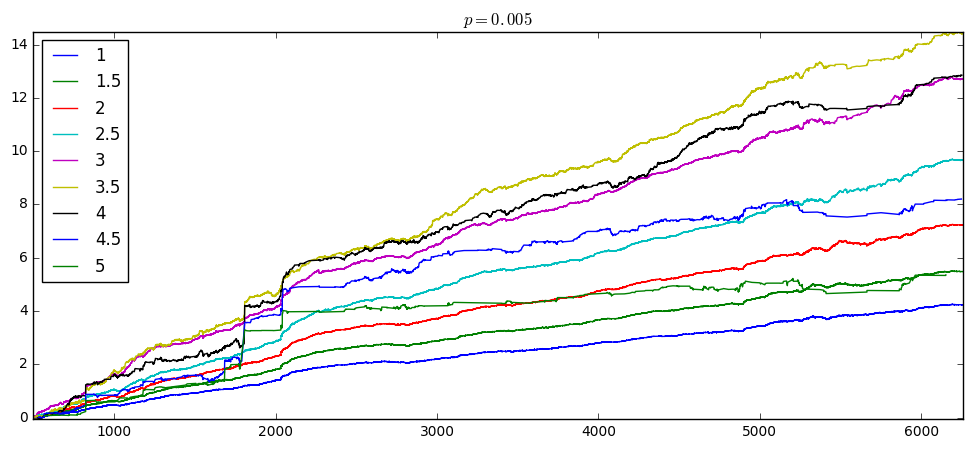

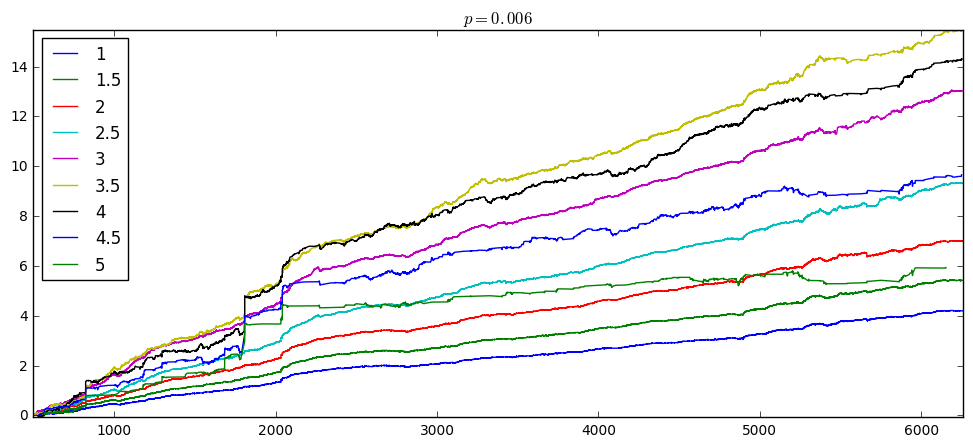

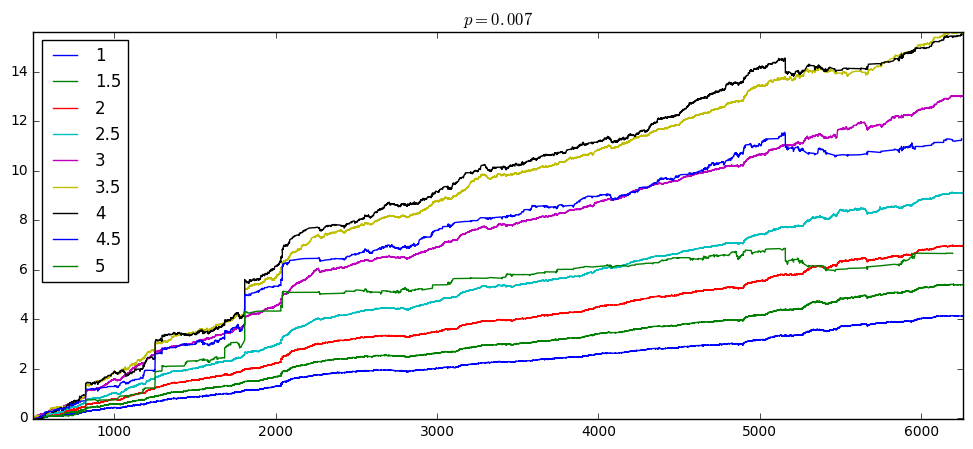

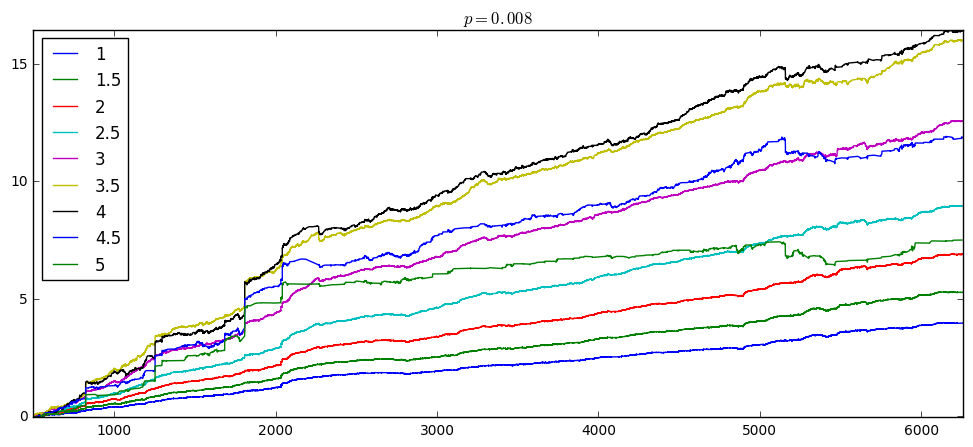

In [9]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500 = sp500
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

T = 500
ps = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3]
ds = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

for p in ps:
    plt.figure()
    plt.title('$p={}$'.format(p))
    for d in ds:
        ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                           p, d, method='thresh-devs')

        plt.plot(ts, np.cumsum(profit))
        plt.autoscale(enable=True, axis='x', tight=True)
        print('p = {}, d = {}, profit = {}, acc = {}'.format(p, d, np.sum(profit),
                                                             np.sum(profit > 0) / len(profit)))
        del(ts, profit)
        
    plt.legend([str(d) for d in ds], loc='best')
    
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


# Grafovi

In [10]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
days, N = sp500.shape
sp500_log = np.log(sp500)
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

T = 500
p = 0.008
d = 4

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
del(sp500, sp500_log)

ts, _, pairs = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                     p, d, method='thresh-devs', return_pairs=True)
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


In [11]:
ppairs = partition_as(ts, pairs)
for t, ppair in ppairs:
    graph = nx.DiGraph()
#     graph.add_nodes_from(range(1, N + 1))
    graph.add_edges_from(ppair)
    layout = nx.drawing.circular_layout(graph)
    nx.drawing.nx_pydot.to_pydot(graph).write_svg('../graphs/output_{:04d}.svg'.format(t),
                                                  prog='neato')


In [14]:
# testiranje
[decode_pair(i, 5, inv=True) for i in range(pairs_from_N(5))]

[(-1, 1),
 (0, 1),
 (1, 1),
 (2, 1),
 (1, 2),
 (2, 2),
 (3, 2),
 (3, 3),
 (4, 3),
 (5, 4)]